In [1]:
'''Imports'''
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
load_path = "./Cleaned Data/Historical/"

In [3]:
pal = sns.color_palette('GnBu', 5)
pal

[(0.8535178777393311, 0.9429757785467128, 0.8314186851211073),
 (0.7058823529411765, 0.8849673202614379, 0.7307189542483661),
 (0.4795847750865052, 0.7984621299500193, 0.7695501730103806),
 (0.2601307189542484, 0.6509803921568628, 0.7999999999999999),
 (0.07497116493656286, 0.4526874279123414, 0.6969319492502883)]

### Data Import and Conversion

In [4]:
'''Data Import'''

#Precipitation
#Precip is in centimeters
precip = pd.read_csv(load_path + 'MEF_precipitation_daily.csv', 
                    parse_dates = ['DATE'])
precip['YEAR'] = precip.DATE.dt.year
precip['MONTH'] = precip.DATE.dt.month
precip['DOY'] = precip.DATE.dt.dayofyear

#Import Air Temperature
airTemp = pd.read_csv(load_path + 'MEF_airTemp_daily.csv', 
                    parse_dates = ['Date'])
airTemp['YEAR'] = airTemp.Date.dt.year
airTemp['MONTH'] = airTemp.Date.dt.month
airTemp['DOY'] = airTemp.Date.dt.dayofyear
airTemp = airTemp[airTemp.STATION == 'South'].reset_index(drop = True)

#Seasonal Soil Moisture
soilMoist = pd.read_csv(load_path + 'MEF_seasonal_soil_moisture.csv', skiprows=1, sep=",",
                names = ["DATE", "LOCATION", "d.15", "d.46", "d.76", "d.107", "d.137", "d.168", "d.198", "d.229", "d.259", "d.290",  "d.320"],
                parse_dates = ['DATE'])
      
bulkDens = pd.read_csv(load_path + 'BulkDensity.csv', skiprows=1, sep=",",
                names = ["watershed", "LOCATION", "horizon", "horizonTop", "horizonBottom", "bulkDensity",  "H2O_1500kPa"])

#Water Table
wteHist = pd.read_csv(load_path + 'MEF_daily_peatland_water_table.csv', 
                parse_dates = ['DATE'])
wte = wteHist[wteHist.PEATLAND == 'S2'].reset_index(drop = True)
wte['YEAR'] = wte.DATE.dt.year

#Streamflow
streamHist = pd.read_csv(load_path + 'S2_Breakpoint_streamflow.csv', 
                parse_dates = ['DateTime'])

#groupby date and average across timestamps
#streamflow interval is total streamflow over the timestamp in mm
streamHist['Year'] = streamHist.DateTime.dt.year
streamHist['Month'] = streamHist.DateTime.dt.month
streamHist['DOY'] = streamHist.DateTime.dt.dayofyear
streamHist_dailyflows = streamHist.groupby(['DOY', 'Year'])['Stage.ft', 'Q.cfs', 'q.mmh', 'Month'].mean().reset_index(drop = False)
streamHist_dailyInterval = streamHist.groupby(['DOY', 'Year'])['q.interval'].sum().reset_index(drop = False)
streamHist_daily = pd.merge(streamHist_dailyInterval, streamHist_dailyflows, on = ['DOY', 'Year'])
streamHist_daily['q_interval_cm'] = streamHist_daily['q.interval']/10

C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\2601474615.py:42: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  streamHist_dailyflows = streamHist.groupby(['DOY', 'Year'])['Stage.ft', 'Q.cfs', 'q.mmh', 'Month'].mean().reset_index(drop = False)


In [5]:
'''Functions'''
import calendar
from functions import *

_MONTHDAYS = (31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)
_LEAP_MONTHDAYS = (31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31)


def thornthwaite(monthly_t, monthly_mean_dlh, year=None):
    """
    Estimate monthly potential evapotranspiration (PET) using the
    Thornthwaite (1948) method.

    Thornthwaite equation:

        *PET* = 1.6 (*L*/12) (*N*/30) (10*Ta* / *I*)***a*

    where:

    * *Ta* is the mean daily air temperature [deg C, if negative use 0] of the
      month being calculated
    * *N* is the number of days in the month being calculated
    * *L* is the mean day length [hours] of the month being calculated
    * *a* = (6.75 x 10-7)*I***3 - (7.71 x 10-5)*I***2 + (1.792 x 10-2)*I* + 0.49239
    * *I* is a heat index which depends on the 12 monthly mean temperatures and
      is calculated as the sum of (*Tai* / 5)**1.514 for each month, where
      Tai is the air temperature for each month in the year

    :param monthly_t: Iterable containing mean daily air temperature for each
        month of the year [deg C].
    :param monthly_mean_dlh: Iterable containing mean daily daylight
        hours for each month of the year (hours]. These can be calculated
        using ``monthly_mean_daylight_hours()``.
    :param year: Year for which PET is required. The only effect of year is
        to change the number of days in February to 29 if it is a leap year.
        If it is left as the default (None), then the year is assumed not to
        be a leap year.
    :return: Estimated monthly potential evaporation of each month of the year
        [mm/month]
    :rtype: List of floats
    """
    if len(monthly_t) != 12:
        raise ValueError(
            'monthly_t should be length 12 but is length {0}.'
            .format(len(monthly_t)))
    if len(monthly_mean_dlh) != 12:
        raise ValueError(
            'monthly_mean_dlh should be length 12 but is length {0}.'
            .format(len(monthly_mean_dlh)))

    if year is None or not calendar.isleap(year):
        month_days = _MONTHDAYS
    else:
        month_days = _LEAP_MONTHDAYS

    # Negative temperatures should be set to zero
    adj_monthly_t = [t * (t >= 0) for t in monthly_t]

    # Calculate the heat index (I)
    I = 0.0
    for Tai in adj_monthly_t:
        if Tai / 5.0 > 0.0:
            I += (Tai / 5.0) ** 1.514

    a = (6.75e-07 * I ** 3) - (7.71e-05 * I ** 2) + (1.792e-02 * I) + 0.49239

    pet = []
    for Ta, L, N in zip(adj_monthly_t, monthly_mean_dlh, month_days):
        # Multiply by 10 to convert cm/month --> mm/month
        pet.append(
            1.6 * (L / 12.0) * (N / 30.0) * ((10.0 * Ta / I) ** a) * 10.0)

    return pet

def monthly_mean_daylight_hours(latitude, year=None):
    """
    Calculate mean daylight hours for each month of the year for a given
    latitude.

    :param latitude: Latitude [radians]
    :param year: Year for the daylight hours are required. The only effect of
        *year* is to change the number of days in Feb to 29 if it is a leap
        year. If left as the default, None, then a normal (non-leap) year is
        assumed.
    :return: Mean daily daylight hours of each month of a year [hours]
    :rtype: List of floats.
    """
    check_latitude_rad(latitude)

    if year is None or not calendar.isleap(year):
        month_days = _MONTHDAYS
    else:
        month_days = _LEAP_MONTHDAYS
    monthly_mean_dlh = []
    doy = 1         # Day of the year
    for mdays in month_days:
        dlh = 0.0   # Cumulative daylight hours for the month
        for daynum in range(1, mdays + 1):
            sd = sol_dec(doy)
            sha = sunset_hour_angle(latitude, sd)
            dlh += daylight_hours(sha)
            doy += 1
        # Calc mean daylight hours of the month
        monthly_mean_dlh.append(dlh / mdays)
    return monthly_mean_dlh

In [6]:
#Convert Soil Moisture to PAW

#Refine to S2 and S6 measurements
sites = ['S2E', 'S2S']
soilMoist_sel = soilMoist.loc[soilMoist.LOCATION.isin(sites)].reset_index()

#Reformat Data
soilMoist_melt = pd.melt(soilMoist_sel, id_vars = ['DATE', 'LOCATION'],
                        value_vars = ['d.15', 'd.46', 'd.76', 'd.107', 'd.137', 'd.168', 'd.198', 'd.229', 'd.259', 'd.290', 'd.320'])
soilMoist_melt.columns = ['DATE', 'LOCATION', 'DEPTH', 'VWC']

#Reformat depths
#soilMoist_melt['DEPTH_CM'] = [string[2:] for string in soilMoist_melt.DEPTH]

#Transform to plant available water
PAW = []
for row_index, row in soilMoist_melt.iterrows():
    #find row in bulk density frame for site and depth
    bulkTemp = bulkDens[(bulkDens.LOCATION == row.LOCATION) & (bulkDens.horizon == row.DEPTH)].reset_index(drop = True)

    #test if bulktemp is at least one row
    if(len(bulkTemp.LOCATION) < 1):
        PAW.append(np.NAN)
        
    else:
        #find depth of sample
        dep = float(bulkTemp.horizonBottom - bulkTemp.horizonTop)
        #print(dep)

        #multiply depth by VWC
        vol = float(row.VWC/100)*dep
        
        #subtract plant unavailable water
        plw = float(vol-(bulkTemp.H2O_1500kPa))

        #if below zero,  set to zero
        if(plw < 0):
            plw = 0

        #record
        PAW.append(plw)

#PAW in cm
soilMoist_melt['PAW'] = PAW

#Add days 
soilMoist_melt['YEAR'] = soilMoist_melt.DATE.dt.year
soilMoist_melt['MONTH'] = soilMoist_melt.DATE.dt.month
soilMoist_melt['DOY'] = soilMoist_melt.DATE.dt.dayofyear

#Sum down the water column for each site/sample
soilMoist_avg = soilMoist_melt.groupby(['LOCATION', 'DATE', 'YEAR', 'MONTH', 'DOY'])['PAW'].sum().reset_index()

In [7]:
'''Convert all data to same timescale'''
SM = soilMoist_avg[(soilMoist_avg.YEAR > 1967) & (soilMoist_avg.YEAR < 2017)].reset_index(drop = True)
P = precip[(precip.YEAR > 1967) & (precip.YEAR < 2017)].reset_index(drop = True)
Q = streamHist_daily[(streamHist_daily.Year > 1967) & (streamHist_daily.Year < 2017)].reset_index(drop = True)
WTE = wte[(wte.YEAR > 1967) & (wte.YEAR < 2017)].reset_index(drop = True)
T = airTemp[(airTemp.YEAR > 1967) & (airTemp.YEAR < 2017)].reset_index(drop = True)

### Basic Budyko Curve (no storage assumption)

In [8]:
'''Compute Basic Budyko Curve'''
#Assume that ET = P - Q on an annual basis

#Aggregate P and Q to annual basis
P_annual = P.groupby(['YEAR'])['South_PCP', 'NADP_PCP', 'North_PCP'].sum().reset_index()
Q_annual = Q.groupby(['Year'])['q_interval_cm'].sum().reset_index()

#Merge
annual_basicBC = pd.merge(P_annual, Q_annual, left_on = 'YEAR', right_on = 'Year')

#Compute ET
annual_basicBC['ET'] = annual_basicBC.South_PCP - annual_basicBC['q_interval_cm']

#Compute PET from PyETO package
ETmax = []
lat = deg2rad(47.5139)
for year in set(T.YEAR):
    temp = T[T.YEAR == year]
    mmdlh = monthly_mean_daylight_hours(lat, year)

    #groupby month for mean daily temp
    temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
    temp_monthly['MEANC'] = (temp_monthly.MINC + temp_monthly.MAXC)/2
    monthly_t = list(temp_monthly.MEANC)
    monthly_et = thornthwaite(monthly_t, mmdlh)
    ETmax.append(np.max(monthly_et))

annual_basicBC['ETmax'] = ETmax

#Dryness Index and Storage Index
annual_basicBC['EP'] = annual_basicBC['ET']/annual_basicBC['South_PCP']
annual_basicBC['DI'] = annual_basicBC['ETmax']/annual_basicBC['South_PCP']

C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\160522579.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  P_annual = P.groupby(['YEAR'])['South_PCP', 'NADP_PCP', 'North_PCP'].sum().reset_index()
C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\160522579.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\160522579.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\160522579.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprec

In [9]:
annual_basicBC.head()

,YEAR,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI
0,1968,89.59,0.0,92.30,1968,1.862934,87.727066,120.668943,0.979206,1.346902
1,1969,77.38,0.0,79.86,1969,2.034193,75.345807,125.467092,0.973712,1.621441
2,1970,67.09,0.0,66.64,1970,1.632906,65.457094,135.628627,0.975661,2.021592
3,1971,83.14,0.0,89.78,1971,1.733026,81.406974,117.927465,0.979155,1.418420
4,1972,80.34,0.0,87.05,1972,1.866032,78.473968,118.099232,0.976773,1.469993


C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\2361282755.py:6: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)


Text(2, 0.1, 'Water Limit\nEnergy Limit')

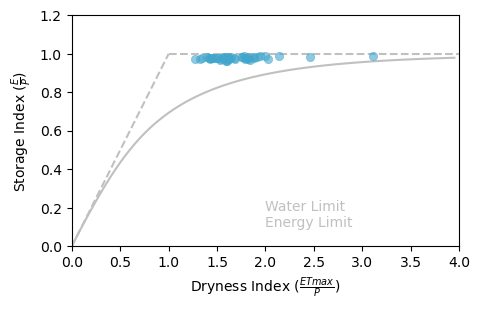

In [10]:
'''Plot Basic Budyko Curve'''
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

#Budyko Estimate
budyko_curve_x = np.arange(0, 4, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax)

#Energy and water limits
energy_limit_x = np.arange(0, 1.0001, 0.05)
water_limit_x = np.arange(1, 4.0001, 0.05)
water_limit_y = 1+water_limit_x*0
energy_limit_y = energy_limit_x

ax.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')

#Annual Water Balance Measurements
sns.scatterplot(data = annual_basicBC, x = 'DI', y = 'EP', 
                ax = ax, color = pal[3], edgecolor = None, alpha = 0.6,
                zorder = 3)

ax.set_xlim(0, 4)
ax.set_ylim(0, 1.2)
ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.set_ylabel(r'Storage Index ($\frac{E}{P})$')
ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')

Bogs??? A water limited environment??? Absolutely not!!!

One reason for this is probably because we are using the max annual ETmax, which typically occurs in July/August but is by no means sustained year round. Therefore we are getting an outsized estimate of dryness in the system. Using mean annual ETmax doesn't really make sense either, we should instead complete this analysis on a seasonal basis.

### Budyko Curve with Storage Consideration

In [11]:
'''Storage Calculation'''
#Calculate annual storage change in the watershed using soil moisture (uplands) and water table (bog)
#Soil Moisture -- take the last measurement in a given year
SM_last = SM.sort_values(['DATE']).groupby(['YEAR', 'LOCATION']).tail(1).reset_index(drop = True)

#Compute difference over years by location
SM_last['deltaPAW'] = SM_last.groupby('LOCATION')['PAW'].diff()

#Average two sites
SM_last_avg = SM_last.groupby(['YEAR'])['deltaPAW'].mean().reset_index()

#Water Table -- take the measurement from January 1st
WTE_last = WTE[WTE.DATE.dt.dayofyear == 1].reset_index(drop = True)
WTE_last['deltaWTE'] = WTE_last.WTE.diff()*100 #plus convert m to cm

#Compute a storage change by area
#S2 peatland is 3.2 (320000000 cm2) hectares and the uplands are 6.5 (650000000 cm2) hectares
SM_last_avg['deltaPAW_watershed'] = SM_last_avg['deltaPAW']*650000000 
WTE_last['deltaWTE_watershed'] = WTE_last['deltaWTE']*320000000

#Merge data
storage = pd.merge(SM_last_avg, WTE_last, on = 'YEAR')
storage = storage.drop(columns = ['PEATLAND', 'FLAG', 'DATE', 'WTE'])

#Compute total storage change and re-normalize by area
storage['deltaS'] = storage.deltaPAW_watershed + storage.deltaWTE_watershed
storage['deltaS_cm'] = storage.deltaS/(650000000 + 320000000)
storage.head()

,YEAR,deltaPAW,deltaPAW_watershed,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,NaN,NaN,NaN,NaN,NaN,NaN
1,1969,-0.398326,-258911900.0,13.0,4.160000e+09,3.901088e+09,4.021740
2,1970,0.203254,132115100.0,2.0,6.400000e+08,7.721151e+08,0.795995
3,1971,0.014116,9175400.0,-5.0,-1.600000e+09,-1.590825e+09,-1.640025
4,1972,-0.417576,-271424400.0,3.0,9.600000e+08,6.885756e+08,0.709872


In [12]:
'''Merge with original Budyko Curve data'''
#Merge
budyko = pd.merge(storage, annual_basicBC, on = 'YEAR')
budyko = budyko.drop(columns = ['NADP_PCP', 'North_PCP', 'Year'])

#Compute new ET/P metric (DI stays the same)
#ET is now P - Q - Storage
budyko['ET_storage'] = budyko.South_PCP - budyko.q_interval_cm - budyko.deltaS_cm
budyko['EP_storage'] = budyko.ET_storage/budyko.South_PCP
budyko.head()

,YEAR,deltaPAW,deltaPAW_watershed,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,NaN,NaN,NaN,NaN,NaN,NaN,89.59,1.862934,87.727066,120.668943,0.979206,1.346902,NaN,NaN
1,1969,-0.398326,-258911900.0,13.0,4.160000e+09,3.901088e+09,4.021740,77.38,2.034193,75.345807,125.467092,0.973712,1.621441,71.324067,0.921738
2,1970,0.203254,132115100.0,2.0,6.400000e+08,7.721151e+08,0.795995,67.09,1.632906,65.457094,135.628627,0.975661,2.021592,64.661099,0.963796
3,1971,0.014116,9175400.0,-5.0,-1.600000e+09,-1.590825e+09,-1.640025,83.14,1.733026,81.406974,117.927465,0.979155,1.418420,83.046999,0.998881
4,1972,-0.417576,-271424400.0,3.0,9.600000e+08,6.885756e+08,0.709872,80.34,1.866032,78.473968,118.099232,0.976773,1.469993,77.764097,0.967937


C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\2605660129.py:6: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)


Text(2, 0.1, 'Water Limit\nEnergy Limit')

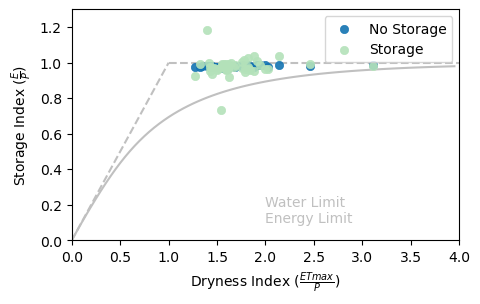

In [13]:
'''Plot Storage + Basic Budyko Curve'''
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

#Budyko Estimate
budyko_curve_x = np.arange(0, 4, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax)

#Energy and water limits
energy_limit_x = np.arange(0, 1.0001, 0.05)
water_limit_x = np.arange(1, 4.0001, 0.05)
water_limit_y = 1+water_limit_x*0
energy_limit_y = energy_limit_x

ax.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')

#Annual Water Balance Measurements
sns.scatterplot(data = budyko, x = 'DI', y = 'EP', 
                ax = ax, color = pal[4], edgecolor = None, alpha = 0.9,
                label = 'No Storage',
                zorder = 3)

#Water Balance with Storage Consideration
sns.scatterplot(data = budyko, x = 'DI', y = 'EP_storage', 
                ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                label = 'Storage',
                zorder = 3)

ax.set_xlim(0, 4)
ax.set_ylim(0, 1.3)
ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.set_ylabel(r'Storage Index ($\frac{E}{P})$')
ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')

### Seasonal Budyko Storage Analysis

In [42]:
'''Add seasonal time components'''
#Spring --> will have deltaS values from over the snow season
#Fall --> will have deltaS values from over the growing season
SM['Season'] = ['Snow' if i < 6 else ('Growing' if i > 8 else 'Summer') for i in SM.MONTH]
WTE['Season'] = ['Snow' if i < 6 else ('Growing' if i > 8 else 'Summer') for i in WTE.DATE.dt.month]

#Remove summer soil moisture data -- not needed because there isn't enough of it
SM = SM[SM.Season != 'Summer']

In [43]:
'''Seasonal Storage Calculations'''
#Calculate annual storage change in the watershed using soil moisture (uplands) and water table (bog)
#Soil Moisture -- take the last measurement in a given year
SM_last_seasonal = SM.sort_values(['DATE']).groupby(['YEAR', 'Season', 'LOCATION']).tail(1).reset_index(drop = True)
#Compute difference over years by location
SM_last_seasonal['deltaPAW'] = SM_last_seasonal.groupby('LOCATION')['PAW'].diff()

#Average two sites
SM_last_seasonal_avg = SM_last_seasonal.groupby(['YEAR', 'Season'])['deltaPAW'].mean().reset_index()

#Water Table -- take the measurement from April 1st or October 1st
WTE_last_seasonal = WTE[(WTE.DATE.dt.dayofyear == 91) | (WTE.DATE.dt.dayofyear == 274)].reset_index(drop = True)
WTE_last_seasonal['deltaWTE'] = WTE_last_seasonal.WTE.diff()*100 #plus convert m to cm

#Compute a storage change by area
#S2 peatland is 3.2 (320000000 cm2) hectares and the uplands are 6.5 (650000000 cm2) hectares
SM_last_seasonal_avg['deltaPAW_watershed'] = SM_last_seasonal_avg['deltaPAW']*650000000 
WTE_last_seasonal['deltaWTE_watershed'] = WTE_last_seasonal['deltaWTE']*320000000

#Merge data
storage_seasonal = pd.merge(SM_last_seasonal_avg, WTE_last_seasonal, on = ['YEAR', 'Season'])
storage_seasonal = storage_seasonal.drop(columns = ['PEATLAND', 'FLAG', 'DATE', 'WTE'])

#Compute total storage change and re-normalize by area
storage_seasonal['deltaS'] = storage_seasonal.deltaPAW_watershed + storage_seasonal.deltaWTE_watershed
storage_seasonal['deltaS_cm'] = storage_seasonal.deltaS/(650000000 + 320000000)
storage_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,Growing,-0.307886,-200125900.0,-1.0,-3.200000e+08,-5.201259e+08,-0.536212
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,2.560000e+09,2.142567e+09,2.208832
3,1969,Snow,0.243878,158520700.0,-4.0,-1.280000e+09,-1.121479e+09,-1.156164
4,1970,Growing,-0.610838,-397044700.0,-10.0,-3.200000e+09,-3.597045e+09,-3.708294


[Text(0, 0, 'Growing Season'), Text(1, 0, 'Snow Season')]

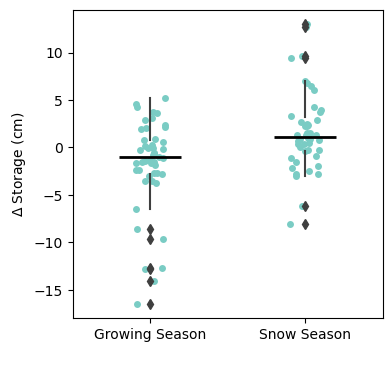

In [44]:
'''Plot Change in Storage'''
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.stripplot(data = storage_seasonal, x = 'Season', y = 'deltaS_cm', 
              color = pal[2], zorder = 0)
sns.boxplot(data = storage_seasonal, x = 'Season', y = 'deltaS_cm',
            showbox = False, showcaps = False, 
            medianprops={"color": "k", "linewidth": 2}, 
            width = 0.4, 
            ax = ax, zorder = 1)

ax.set_ylabel(r'$\Delta$ Storage (cm)')
ax.set_xlabel(' ')
ax.set_xticklabels(['Growing Season', 'Snow Season'])

In [45]:
'''Compute Seasonal Climate Data'''
P['Season'] = ['Growing' if (i > 3) & (i < 11) else 'Snow' for i in P.MONTH]
Q['Season'] = ['Growing' if (i > 3) & (i < 11) else 'Snow' for i in Q.Month]


#Aggregate P and Q to seasonal basis
P_seasonal = P.groupby(['YEAR', 'Season'])['South_PCP', 'NADP_PCP', 'North_PCP'].sum().reset_index()
Q_seasonal = Q.groupby(['Year', 'Season'])['q_interval_cm'].sum().reset_index()


#Merge
seasonal_basicBC = pd.merge(P_seasonal, Q_seasonal, left_on = ['YEAR', 'Season'], right_on = ['Year', 'Season'])


#Compute ET
seasonal_basicBC['ET'] = seasonal_basicBC.South_PCP - seasonal_basicBC['q_interval_cm']

#Compute PET from PyETO package
ETmax_growing = []
ETmax_winter = []
lat = deg2rad(47.5139)
for year in set(T.YEAR):
    temp = T[T.YEAR == year]
    mmdlh = monthly_mean_daylight_hours(lat, year)

    #groupby month for mean daily temp
    temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
    temp_monthly['MEANC'] = (temp_monthly.MINC + temp_monthly.MAXC)/2
    monthly_t = list(temp_monthly.MEANC)
    monthly_et = thornthwaite(monthly_t, mmdlh)

    ETmax_growing.append(np.max(monthly_et[4:-2])) 
    ETmax_winter.append(np.max(monthly_et[0:4] + monthly_et[-2:]))


#Separate out to add ET
growingBC = seasonal_basicBC[seasonal_basicBC.Season == 'Growing']
growingBC['ETmax'] = ETmax_growing
winterBC = seasonal_basicBC[seasonal_basicBC.Season == 'Snow']
winterBC['ETmax'] = ETmax_winter

#Re-concatenate
basic_budyko = pd.concat([growingBC, winterBC])

#Dryness Index and Storage Index
basic_budyko['EP'] = basic_budyko['ET']/basic_budyko['South_PCP']
basic_budyko['DI'] = basic_budyko['ETmax']/basic_budyko['South_PCP']

basic_budyko.head()


C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\1418931922.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  P_seasonal = P.groupby(['YEAR', 'Season'])['South_PCP', 'NADP_PCP', 'North_PCP'].sum().reset_index()
C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\1418931922.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\1418931922.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_monthly = temp.groupby(['MONTH'])['MINC', 'MAXC'].mean().reset_index()
C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\1418931922.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys

,YEAR,Season,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI
0,1968,Growing,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540
2,1969,Growing,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227
4,1970,Growing,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744
6,1971,Growing,63.91,0.0,69.24,1971,1.546795,62.363205,117.927465,0.975797,1.845211
8,1972,Growing,64.95,0.0,70.82,1972,1.829777,63.120223,118.099232,0.971828,1.818310


In [46]:
storage_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm
0,1968,Growing,-0.307886,-200125900.0,-1.0,-3.200000e+08,-5.201259e+08,-0.536212
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,2.560000e+09,2.142567e+09,2.208832
3,1969,Snow,0.243878,158520700.0,-4.0,-1.280000e+09,-1.121479e+09,-1.156164
4,1970,Growing,-0.610838,-397044700.0,-10.0,-3.200000e+09,-3.597045e+09,-3.708294


In [48]:
'''Merge seasonal storage data with original Budyko Curve data'''
#Merge
budyko_seasonal = pd.merge(storage_seasonal, basic_budyko, on = ['YEAR', 'Season'])
#budyko_seasonal = budyko_seasonal.drop(columns = ['NADP_PCP', 'North_PCP', 'Year'])

#Compute new ET/P metric (DI stays the same)
#ET is now P - Q - Storage
budyko_seasonal['ET_storage'] = budyko_seasonal.South_PCP - budyko_seasonal.q_interval_cm - budyko_seasonal.deltaS_cm
budyko_seasonal['EP_storage'] = budyko_seasonal.ET_storage/budyko_seasonal.South_PCP
budyko_seasonal.head()

,YEAR,Season,deltaPAW,deltaPAW_watershed,deltaWTE,deltaWTE_watershed,deltaS,deltaS_cm,South_PCP,NADP_PCP,North_PCP,Year,q_interval_cm,ET,ETmax,EP,DI,ET_storage,EP_storage
0,1968,Growing,-0.307886,-200125900.0,-1.0,-3.200000e+08,-5.201259e+08,-0.536212,72.80,0.0,74.58,1968,1.798235,71.001765,120.668943,0.975299,1.657540,71.537977,0.982665
1,1968,Snow,NaN,NaN,NaN,NaN,NaN,NaN,16.79,0.0,17.72,1968,0.064699,16.725301,27.977955,0.996147,1.666346,NaN,NaN
2,1969,Growing,-0.642204,-417432600.0,8.0,2.560000e+09,2.142567e+09,2.208832,57.68,0.0,60.08,1969,1.882567,55.797433,125.467092,0.967362,2.175227,53.588601,0.929067
3,1969,Snow,0.243878,158520700.0,-4.0,-1.280000e+09,-1.121479e+09,-1.156164,19.70,0.0,19.78,1969,0.151626,19.548374,33.093301,0.992303,1.679863,20.704538,1.050992
4,1970,Growing,-0.610838,-397044700.0,-10.0,-3.200000e+09,-3.597045e+09,-3.708294,51.99,0.0,51.13,1970,1.417166,50.572834,135.628627,0.972742,2.608744,54.281128,1.044069


C:\Users\jone3247\AppData\Local\Temp\ipykernel_19208\287894229.py:9: RuntimeWarning: divide by zero encountered in divide
  budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)


Text(2, 0.1, 'Water Limit\nEnergy Limit')

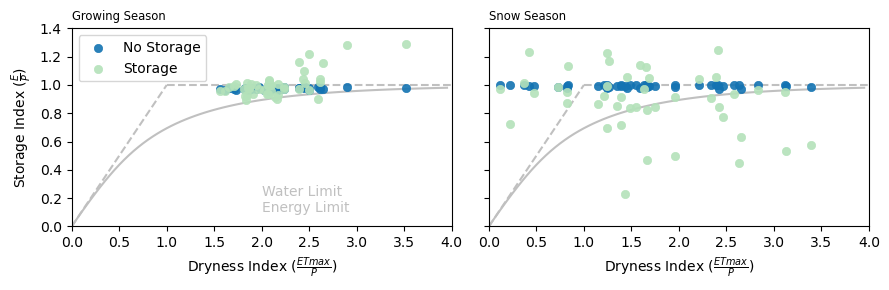

In [55]:
#Plot Seasonal Storage and no-storage Budyko
fig, [ax, ax2] = plt.subplots(1, 2, figsize = (9, 3), 
                            sharex = True, 
                            sharey = True, 
                            layout = 'tight')

#Budyko Estimate
budyko_curve_x = np.arange(0, 4, 0.05)
budyko_curve_y = np.power((budyko_curve_x*np.tanh(1/budyko_curve_x)*(1-np.exp(-budyko_curve_x))),0.5)

#Energy and water limits
energy_limit_x = np.arange(0, 1.0001, 0.05)
water_limit_x = np.arange(1, 4.0001, 0.05)
water_limit_y = 1+water_limit_x*0
energy_limit_y = energy_limit_x

#Plot 1: Growing Season
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax)
ax.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')
#Annual Water Balance Measurements
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Growing'], x = 'DI', y = 'EP', 
                ax = ax, color = pal[4], edgecolor = None, alpha = 0.9,
                label = 'No Storage',
                zorder = 3)

#Water Balance with Storage Consideration
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Growing'], x = 'DI', y = 'EP_storage', 
                ax = ax, color = pal[1], edgecolor = None, alpha = 0.9,
                label = 'Storage',
                zorder = 3)
ax.set_title('Growing Season', loc = 'left', fontsize = 'small')

#Plot 2: Winter Season
sns.lineplot(x = budyko_curve_x, y = budyko_curve_y, color = 'silver', 
             ax = ax2)
ax2.plot(energy_limit_x, energy_limit_y, 
             color = 'silver', linestyle = '--')
ax2.plot(water_limit_x, water_limit_y, 
             color = 'silver', linestyle = '--')
#Annual Water Balance Measurements
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Snow'], x = 'DI', y = 'EP', 
                ax = ax2, color = pal[4], edgecolor = None, alpha = 0.9,
                zorder = 3)

#Water Balance with Storage Consideration
sns.scatterplot(data = budyko_seasonal[budyko_seasonal.Season == 'Snow'], x = 'DI', y = 'EP_storage', 
                ax = ax2, color = pal[1], edgecolor = None, alpha = 0.9,
                zorder = 3)
ax2.set_title('Snow Season', loc = 'left', fontsize = 'small')


ax.set_xlim(0, 4)
ax.set_ylim(0, 1.4)
ax.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.set_ylabel(r'Storage Index ($\frac{E}{P})$')
ax2.set_xlabel(r'Dryness Index ($\frac{ETmax}{P})$')
ax.text(2, 0.1, "Water Limit\nEnergy Limit", color = 'silver')